In [84]:
import pymongo as py
import pandas as pd
import datetime
import pprint
import matplotlib.pyplot as plt
import numpy as np

client = py.MongoClient('localhost', 27017)
db = client['Stocks']
stocks = db.list_collection_names()

In [2]:
def get_stock_dataframe(stock, features, start_date, end_date, db):
    
    c = db[stock]
    cols = ['Date'] + features
    df = pd.DataFrame([], columns=cols)
    
    for thing in c.find():
        date = thing['Date']
        if date > start_date and date < end_date:

            ans = [None for _ in range(len(features))]
            
            for i in range(len(features)):
                try:
                    ans[i] = thing[features[i]]
                except:
                    pass
            
            ans=[date]+ans     
            row = pd.DataFrame([ans], columns=cols)      
            df = df.append(row)
    
    df = df.set_index('Date')
    df = df.sort_index()
    return df

In [3]:
def get_annual_datapoint(stock, features, year, db):
    
    c = db[stock]
    cols = ['Date'] + features
    ans = [None for _ in range(len(features))]
    
    for thing in c.find():
        date = thing['Date']
        if date.year == year: 
            for i in range(len(features)):
                try:
                    ans[i] = thing[features[i]]
                except:
                    pass

    return ans

In [14]:
def get_annual_features_dataframe(stocks, features, year, db):
    
    cols = ['Stock'] + features
    df = pd.DataFrame([], columns=cols)
    
    for stock in stocks:
        data = get_annual_datapoint(stock, features, year, db)
        
        ans = [stock] + data
        row = pd.DataFrame([ans], columns=cols)      
        df = df.append(row)
    
    return df

In [54]:
# returns for 1996 are (1996 end price - 1995 end price (1996 start price))/1995 price
def calc_returns(stocks, year, db):
        
    cols = ['Stock', 'Returns']
    df = pd.DataFrame([], columns=cols)
    
    for stock in stocks:
        old = get_annual_datapoint(stock, ["LAST_PRICE"], year-1, db)
        new = get_annual_datapoint(stock, ["LAST_PRICE"], year, db)
        old_price = old[0]
        new_price = new[0]
        r = None
        try:
            r = (new_price - old_price) / old_price
        except:
            pass
        ans = [stock, r]
        row = pd.DataFrame([ans], columns=cols)      
        df = df.append(row)
    
    return df


In [57]:
# 1996 <= year <= 2017
def compare_returns(year, sp500_returns, r2000_returns, all_stocks, db):
    sp500 = sp500_returns[year-1996]
    r2000 = r2000_returns[year-1996]
    
    rdf = calc_returns(all_stocks, year, db)
    rdf = rdf.sort_values(by=['Returns'], ascending=False).head(20)
    ideal = rdf['Returns'].sum()/20
    
    edf = get_annual_features_dataframe(stocks, ['EBITDA'], year, db)
    edf = edf.sort_values(by='EBITDA', ascending=False).head(20)
    edf_r = calc_returns(edf['Stock'], year, db)
    test = edf_r['Returns'].sum()/20
    
    return sp500, r2000, ideal, test

In [73]:
# from http://www.1stock1.com/1stock1_141.htm
# from 1996 to 2017 (1995's annual ending price to 2017's annual ending price)
sp500_returns = [0.2026, 0.3101, 0.2667, 0.1953, -0.1014, -0.1304, -0.2337, 0.2638, 0.0899, 0.03, 0.1362,
                 0.0363, -0.3849, 0.2345, 0.1278, 0, 0.1341, 0.2960, 0.1139, -0.0073, 0.0954, 0.1942]

# from http://www.1stock1.com/1stock1_784.htm
# ditto
r2000_returns = [0.1476, 0.2052, -0.0345, 0.1962, -0.042, 0.0103, -0.2158, 0.4537, 0.17, 0.0332, 0.17,
                 -0.0275, -0.3480, 0.2522, 0.2531, -0.0545, 0.1463, 0.37, 0.0353, -0.0571, 0.1948, 0.1314]

years = range(1996, 2018)

s_points = [0 for _ in years]
r_points = [0 for _ in years]
i_points = [0 for _ in years]
t_points = [0 for _ in years]

for year in years:
    s, r, i, t = compare_returns(year, sp500_returns, r2000_returns, stocks, db)
    s_points[year-1996] = s
    r_points[year-1996] = r
    i_points[year-1996] = i
    t_points[year-1996] = t

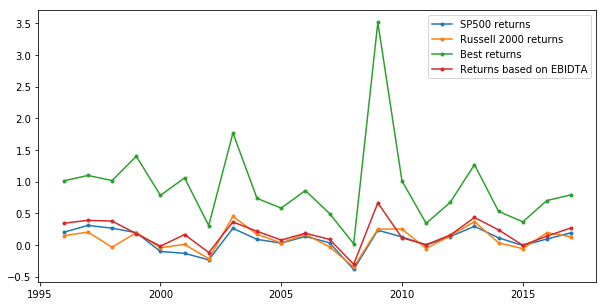

In [86]:
plt.figure(figsize=(10,5))
plt.plot(years, s_points, marker='.')
plt.plot(years, r_points, marker='.')
plt.plot(years, i_points, marker='.')
plt.plot(years, t_points, marker='.')
plt.legend(['SP500 returns', 'Russell 2000 returns', 'Best returns', 'Returns based on EBIDTA'])
plt.show()